In [61]:
import torch
import torch.utils.data
import torchvision

import sys
sys.path.insert(1, 'detection')
from engine import train_one_epoch, evaluate
import utils

from CustomCocoDataset import CustomCocoDataset

data_dir = 'data/laser_v3/'

data_dir_images = data_dir + 'images'
data_dir_annotations = data_dir + 'annotations/instances_default.json'

def get_transform(train=None):
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    if train:
        custom_transforms.append(torchvision.transforms.RandomHorizontalFlip())
        custom_transforms.append(torchvision.transforms.RandomVerticalFlip())
        #custom_transforms.append(torchvision.transforms.RandomPosterize())
       # custom_transforms.append(torchvision.transforms.RandomSolarize())
        custom_transforms.append(torchvision.transforms.RandomAdjustSharpness(2))
        custom_transforms.append(torchvision.transforms.RandomAdjustSharpness(0))
        custom_transforms.append(torchvision.transforms.RandomAutocontrast())
        #custom_transforms.append(torchvision.transforms.RandomEqualize())
    return torchvision.transforms.Compose(custom_transforms)


dataset = CustomCocoDataset(root=data_dir_images,
                          annotation=data_dir_annotations,
                          transforms=get_transform(True)
                          )
dataset_val = CustomCocoDataset(root=data_dir_images,
                          annotation=data_dir_annotations,
                          transforms=get_transform(False)
                          )
dataset_test = CustomCocoDataset(root=data_dir_images,
                          annotation=data_dir_annotations,
                          transforms=get_transform(False)
                          )

indices = torch.randperm(len(dataset)).tolist()

dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

data_loader_test = torch.utils.data.DataLoader(dataset_test, 
                                               batch_size=1, 
                                               shuffle=False, 
                                               num_workers=4,
                                               collate_fn=utils.collate_fn)

for images, image_ids in dataset_test:
    print ('aaaaa')



for images, image_ids in data_loader_test:
    print ('asdasd')



    

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
asdasd
asdasd
asdasd
asdasd
asdasd
asdasd
asdasd
asdasd
asdasd
asdasd


In [ ]:
#runfile('/home/tori/TelePhysicalOperation/src/tpo_vision/pytorchScripts/TestModel.py', wdir='/home/tori/TelePhysicalOperation/src/tpo_vision/pytorchScripts')

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ensemble_boxes import weighted_boxes_fusion

detection_threshold = 0.5
results = []
outputs = []
test_images = []

def make_ensemble_predictions(images, models):
    result = []
    for net in models:
        net.eval()
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.55, skip_box_thr=0.5, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

def test(test_data_loader, models, device):

    with torch.no_grad():

        for images, image_ids in test_data_loader:
            images = list(image.to(device) for image in images)    
            predictions = make_ensemble_predictions(images, models)
        
            for i, image in enumerate(images):
                test_images.append(image) #Saving image values
                boxes, scores, labels = run_wbf(predictions, image_index=i)
        
                boxes = boxes.astype(np.int32).clip(min=0, max=1023)
                    
                preds = boxes
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = preds[preds_sorted_idx]
                boxes = preds
                
                output = {
                    'boxes': boxes,
                    'scores': scores
                }

        outputs.append(output) #Saving outputs and scores
        image_id = image_ids[i]
        
        
        ########### show images results
        fig, axs = plt.subplots(2, 5, figsize=(32, 16))
        axs = axs.ravel()
        for i in range(10):
            sample = test_images[i].permute(1,2,0).cpu().numpy()
            boxes = outputs[i]['boxes']
            scores = outputs[i]['scores']
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
        
            for box in boxes:
                print(sample)
                cv2.rectangle(sample,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (220, 0, 0), 2)
        
            axs[i].set_axis_off()
            axs[i].imshow(sample)

In [ ]:
###testing setup
models = []

model_path = 'model1.pt'
model = None
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA available, use GPU")
    model = torch.load(model_path)

else:
    device = torch.device('cpu')
    print("CUDA not available, use CPU") 
    model = torch.load(model_path, map_location=torch.device('cpu'))

model.eval()
model.to(device)

models.append(model)

0
[[[0.29803923 0.22352941 0.2       ]
  [0.3019608  0.22745098 0.20392157]
  [0.30588236 0.23921569 0.21176471]
  ...
  [0.61960787 0.6        0.58431375]
  [0.627451   0.59607846 0.58431375]
  [0.6509804  0.6117647  0.6039216 ]]

 [[0.29411766 0.21960784 0.19607843]
  [0.30588236 0.23921569 0.21176471]
  [0.3254902  0.25882354 0.23137255]
  ...
  [0.627451   0.60784316 0.59607846]
  [0.6313726  0.6117647  0.59607846]
  [0.654902   0.62352943 0.6117647 ]]

 [[0.30980393 0.24313726 0.21568628]
  [0.3019608  0.23529412 0.20784314]
  [0.3137255  0.25490198 0.22745098]
  ...
  [0.627451   0.62352943 0.60784316]
  [0.63529414 0.62352943 0.6039216 ]
  [0.63529414 0.62352943 0.6039216 ]]

 ...

 [[0.28627452 0.23137255 0.21960784]
  [0.25882354 0.21568628 0.2       ]
  [0.23921569 0.20392157 0.18431373]
  ...
  [0.08627451 0.04705882 0.00784314]
  [0.08235294 0.03137255 0.        ]
  [0.09019608 0.03921569 0.00784314]]

 [[0.30980393 0.24705882 0.25882354]
  [0.29803923 0.23529412 0.24705882

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


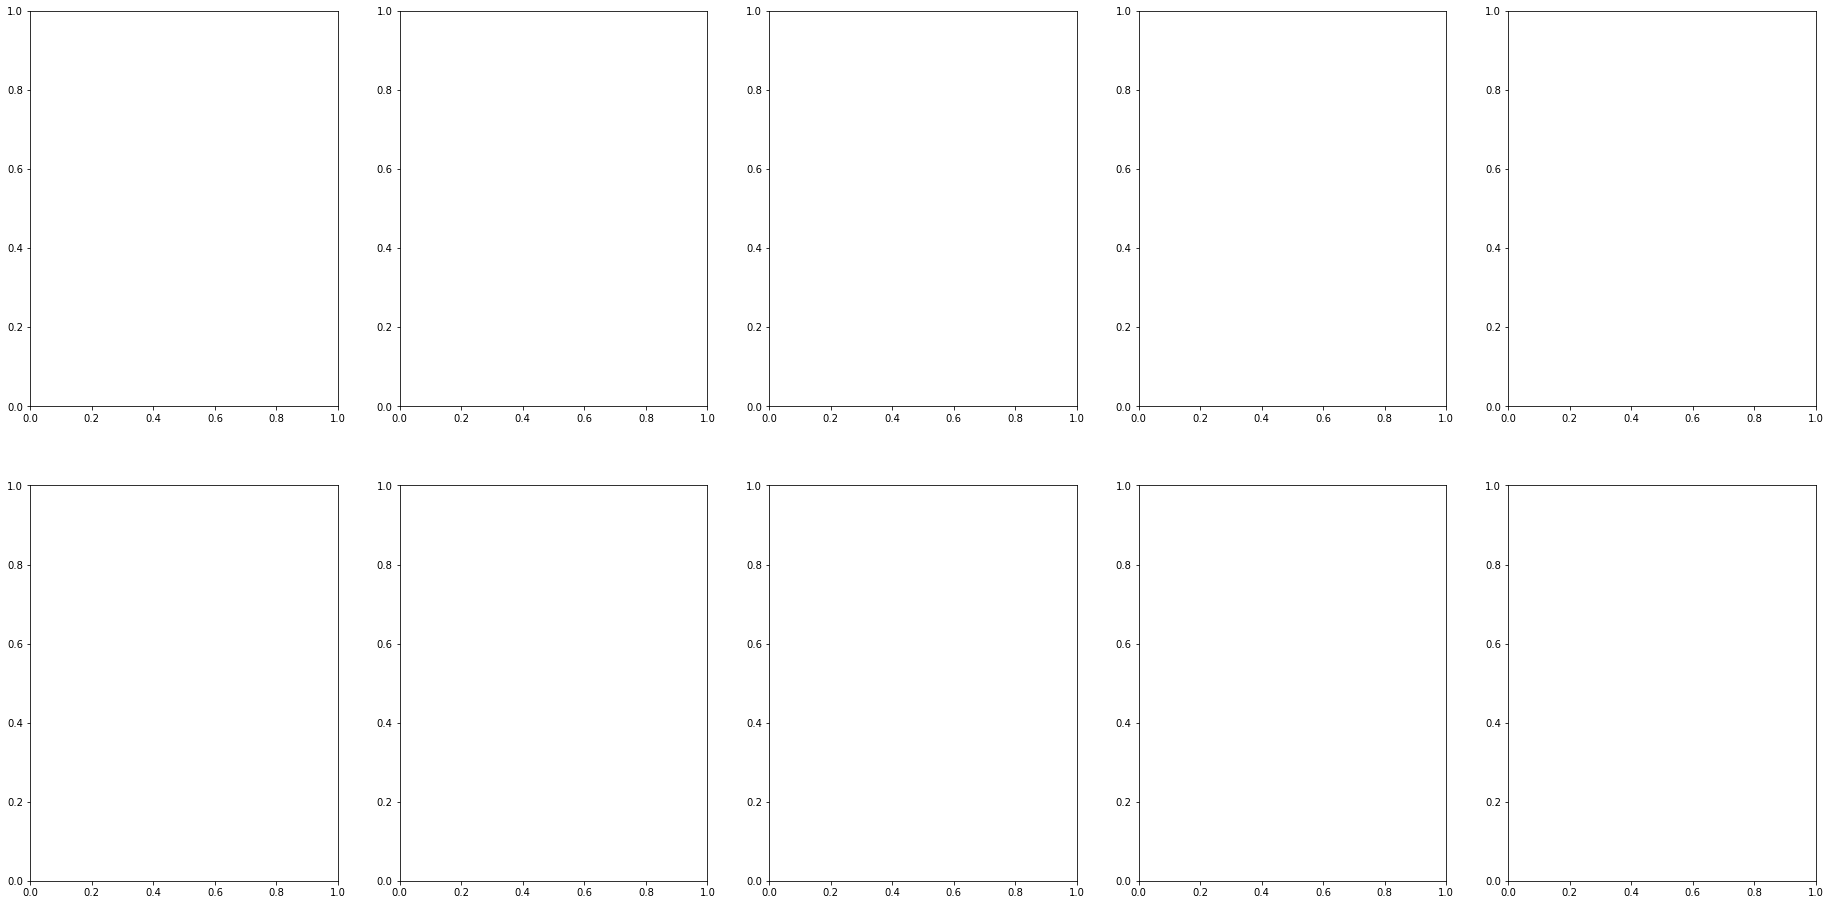

In [67]:
test(data_loader_test, models, device)
